In [40]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import random
from matern_kernel import matern_kernel_noise_batch
import torch.nn.functional as F
import torchda
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [41]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [42]:
def add_matern_kernel_noise_batch(sample, nu=2.5, lengthscale=1.0, sigma=1.0):
    B, C, H, W = sample.shape
    x = torch.linspace(0, 1, W, device=sample.device)
    y = torch.linspace(0, 1, H, device=sample.device)
    xx, yy = torch.meshgrid(x, y, indexing="xy")
    coords = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    noise, _ = matern_kernel_noise_batch(
        sample=sample,
        coords=coords,
        nu=nu,
        lengthscale=lengthscale,
        sigma=sigma,
    )
    return sample + noise

In [43]:
def resize_encoder(sample):
    sample = F.interpolate(
        sample, size=(144, 72), mode="bicubic", align_corners=False
    )
    return sample


def random_mask(sample, mask_prob_low=0.7, mask_prob_high=0.7):
    if mask_prob_low == mask_prob_high:
        mask_prob = mask_prob_low
    else:
        mask_prob = random.uniform(mask_prob_low, mask_prob_high)
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image


class WeatherBenchDatasetWindow(Dataset):
    def __init__(self, data, context_length, stride=1):
        self.data = data
        self.context_length = context_length
        self.stride = stride

    def __len__(self):
        return (self.data.shape[0] - (self.context_length)) // self.stride + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.context_length]
        x_resize = resize_encoder(x)
        return x, x_resize

In [44]:
def prepare_inputs(input_data, encoder_model):
    B, T, C, H, W = input_data.shape
    input_data = input_data.reshape(B * T, C, H, W)
    input_encoded_data, _ = encoder_model(input_data)
    input_encoded_data = input_encoded_data.reshape(B, T, -1)
    return input_encoded_data

In [45]:
def get_background_obs(input_data, seq2seq_model):
    model_pred = seq2seq_model(input_data)
    if model_pred.ndim == 2:
        model_pred = model_pred.unsqueeze(0)
    B, T, L = model_pred.shape
    model_pred = model_pred.reshape(B * T, L)
    return model_pred

In [46]:
seq2seq_model = torch.load(
    "downstream_model_no_decoder.pth", weights_only=False, map_location=DEVICE
)
model = torch.load(
    "det_autoencoder.pth", weights_only=False, map_location=DEVICE
)
model.eval()
seq2seq_model.eval()

encoder_model = model.encoder
decoder_model = model.decoder

data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
data = data[n_train + n_valid :]
BATCH_SIZE = 128
n_samples = data.shape[0]

n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)

train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std

In [47]:
test_dataset = WeatherBenchDatasetWindow(
    data=test_data, context_length=100, stride=1
)
testloader = DataLoader(test_dataset, batch_size=None, shuffle=False)
print(len(testloader))

838


In [48]:
mse_loss = torch.nn.MSELoss()

In [49]:
decoding_mean_loss = []
assimlated_mean_loss = []
for i, batch in enumerate(testloader):
    if i >= 10:
        break
    data = batch[0].to(DEVICE)
    data_enc = batch[1].to(DEVICE)

    decode_loss = []
    assimlated_loss = []

    c_d = data_enc[0].unsqueeze(0)
    with torch.no_grad():
        c_d, _ = encoder_model(c_d)

    for idx, (d, d_enc) in enumerate(zip(data[1:], data_enc[1:])):

        xb = seq2seq_model(c_d.unsqueeze(0)).squeeze(0)
        d_enc.unsqueeze_(0)
        d.unsqueeze_(0)
        d_enc = random_mask(d_enc, mask_prob_low=0.95, mask_prob_high=0.95)
        with torch.no_grad():
            y, _ = encoder_model(d_enc)

        B = torch.eye(y.shape[1], device=DEVICE)
        R = 0.1 * torch.eye(y.shape[1], device=DEVICE)
        results_3dvar = (
            torchda.CaseBuilder()
            .set_background_covariance_matrix(B)
            .set_observation_covariance_matrix(R)
            .set_observations(y)
            .set_background_state(xb)
            .set_algorithm(torchda.Algorithms.Var3D)
            .set_device(DEVICE)
            .set_observation_model(
                # H should be identity function as background and observations live in the same space
                lambda x: x
            )
            .set_optimizer_cls(torch.optim.Adam)
            .set_optimizer_args({"lr": 0.01})
            .set_max_iterations(500)
            .set_record_log(False)
            .execute()
        )

        results = results_3dvar["assimilated_state"]
        c_d = torch.cat((c_d, results), dim=0)

        with torch.no_grad():
            decoded_results = model.decoder(results)
        loss = mse_loss(decoded_results, d)

        assimlated_loss.append(loss.item())
        with torch.no_grad():
            y_dec = model.decoder(y)
        loss = mse_loss(y_dec, d)
        decode_loss.append(loss.item())

    print(assimlated_loss)
    print(decode_loss)
    decoding_mean_loss.append(decode_loss)
    assimlated_mean_loss.append(assimlated_loss)
print(f"Assimlated MSE Loss: {np.mean(assimlated_mean_loss, axis=0)}")
print(f"Decoded Masked MSE Loss: {np.mean(decoding_mean_loss, axis=0)}")

[0.09079449623823166, 0.0940055325627327, 0.08961575478315353, 0.09231162071228027, 0.08968085795640945, 0.09017935395240784, 0.09141113609075546, 0.09312596917152405, 0.09681131690740585, 0.10794335603713989, 0.09218396246433258, 0.09434877336025238, 0.10233273357152939, 0.10519567877054214, 0.09929025918245316, 0.0975886806845665, 0.10073200613260269, 0.10385887324810028, 0.1082487478852272, 0.10356993973255157, 0.0926525741815567, 0.1058071032166481, 0.08757273852825165, 0.09064105898141861, 0.08950452506542206, 0.09639783948659897, 0.09988217055797577, 0.1058146134018898, 0.09383823722600937, 0.09767040610313416, 0.08650237321853638, 0.09394215047359467, 0.10410521179437637, 0.08940599858760834, 0.09093204885721207, 0.09120279550552368, 0.09123899042606354, 0.09759189188480377, 0.09569835662841797, 0.08788655698299408, 0.09489745646715164, 0.08138003200292587, 0.09264141321182251, 0.09426745027303696, 0.10210815817117691, 0.10420538485050201, 0.10322628915309906, 0.0994338467717170

In [50]:
print(f"Assimlated MSE Loss: {np.mean(assimlated_mean_loss, axis=0)}")
print(f"Decoded Masked MSE Loss: {np.mean(decoding_mean_loss, axis=0)}")

Assimlated MSE Loss: [0.09306286 0.09322852 0.09174676 0.09100774 0.09349267 0.09441059
 0.0945939  0.0947527  0.09633732 0.09841046 0.09628597 0.09666573
 0.09566441 0.09535085 0.09597227 0.09562179 0.09323453 0.09504168
 0.09670774 0.09600339 0.09553562 0.0950075  0.09476122 0.09387666
 0.09618892 0.09371979 0.09564027 0.09275059 0.09102566 0.09122789
 0.0917161  0.09151621 0.09242929 0.09053762 0.09065981 0.09447696
 0.09444426 0.09537476 0.09741777 0.09502141 0.09492022 0.09631673
 0.09651962 0.09691308 0.09626173 0.09784018 0.09595851 0.0929131
 0.09440455 0.10090362 0.09614652 0.09595056 0.09589078 0.09873403
 0.09609848 0.09691017 0.09767659 0.09786508 0.09477959 0.09353524
 0.09494182 0.09477887 0.09443859 0.09554543 0.09752439 0.10010467
 0.10200997 0.1000063  0.10501186 0.10225464 0.10249543 0.10420982
 0.0980201  0.10115539 0.09627438 0.09618491 0.09323987 0.09485465
 0.09426565 0.09444561 0.0961666  0.10101206 0.10152048 0.09750982
 0.10185578 0.09775863 0.10380233 0.102157

In [51]:
assimlated_mean_loss = np.mean(assimlated_mean_loss, axis=0)
decoding_mean_loss = np.mean(decoding_mean_loss, axis=0)

t = np.arange(len(assimlated_mean_loss))

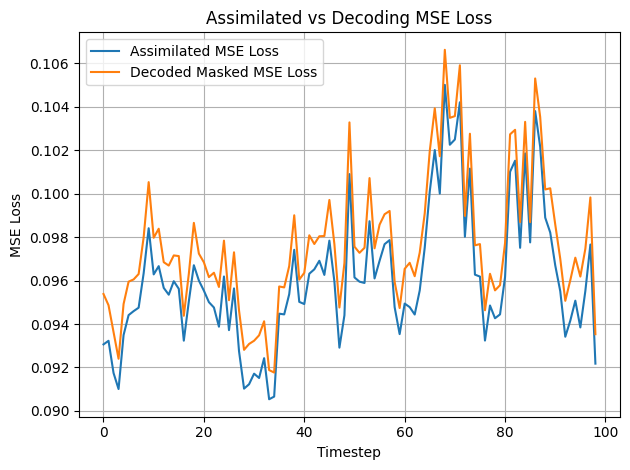

In [52]:
plt.plot(t, assimlated_mean_loss, label="Assimilated MSE Loss")
plt.plot(t, decoding_mean_loss, label="Decoded Masked MSE Loss")

plt.xlabel("Timestep")
plt.ylabel("MSE Loss")
plt.title("Assimilated vs Decoding MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# decode_loss = []
# assimlated_loss = []

# for batch in testloader:
#     data = batch[2].to(DEVICE)
#     B, T, C, H, W = data.shape
#     data = data.reshape(B*T, C, H, W)
#     clean_data = batch[0].to(DEVICE)
#     masked_data = batch[1].to(DEVICE)
#     B, T, C, H, W = masked_data.shape
#     masked_data = masked_data.reshape(B*T, C, H, W)
#     masked_data, R = add_matern_kernel_noise_batch(masked_data)
#     print(R.shape)
#     masked_latent, _ = encoder_model(masked_data)
#     clean_data_prep = prepare_inputs(clean_data, encoder_model)
#     clean_latent = get_background_obs(clean_data_prep, seq2seq_model)
#     xb = clean_latent
#     y = masked_latent
#     B = torch.eye(y.shape[1], device=DEVICE)
#     R = 0.5 * torch.eye(y.shape[1], device=DEVICE)
#     results_3dvar = torchda.CaseBuilder().set_background_covariance_matrix(
#         B
#     ).set_observation_covariance_matrix(R).set_observations(
#         y
#     ).set_background_state(
#         xb
#     ).set_algorithm(
#         torchda.Algorithms.Var3D
#     ).set_device(
#         DEVICE
#     ).set_observation_model(
#         # H should be identity function as background and observations live in the same space
#         lambda x: x
#     ).set_optimizer_cls(
#         torch.optim.Adam
#     ).set_optimizer_args(
#         {"lr": 0.01}
#     ).set_max_iterations(
#         500
#     ).execute()
#     results = results_3dvar['assimilated_state']
#     decoded_results = model.decoder(results)
#     loss = mse_loss(decoded_results, data)

#     assimlated_loss.append(loss.item())
#     loss = mse_loss(model.decoder(masked_latent), data)
#     decode_loss.append(loss.item())


# print(f"Assimlated MSE Loss: {np.mean(assimlated_loss):.5f}")
# print(f"Decoded Masked MSE Loss: {np.mean(decode_loss):.5f}")

: 